## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch

from evaluate import RuleEvaluation, DDQNEvaluation, Plotter
from agent import DDQNAgent

import gym_env

seed = 2705
TRAIN = True

/Users/jorisholshuijsen/Documents/Artificial Intelligence/1e Jaar/Reinforcement Learning Project/BatteryGrid/venv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(


### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [2]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) / 1000 # Convert price per MWh to price per KWh
    return df_long.reset_index(drop=True)

train = elongate(pd.read_excel('data/train.xlsx'))
val = elongate(pd.read_excel('data/validate.xlsx'))


## RULE BASED AGENT

In [52]:
# Evaluate Rule-Based Agent
price_horizon = 80
df = train

rule_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
rule_env.setup(df, price_horizon=price_horizon)
eval_rule = RuleEvaluation(df, rule_env)
eval_rule.evaluate(eval_rule.percentile_strategy)



/Users/jorisholshuijsen/Documents/Artificial Intelligence/1e Jaar/Reinforcement Learning Project/BatteryGrid/venv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/jorisholshuijsen/Documents/Artificial Intelligence/1e Jaar/Reinforcement Learning Project/BatteryGrid/venv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.price_horizon to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.price_horizon` for environment variables or `env.get_wrapper_attr('price_horizon')` that will search the reminding wrappers.
  logger.warn(


[-9691.453788583, -9143.966123412001, -9654.823836779999, -9381.493237945999, -9506.064405895999, -9292.379089604, -9074.483181524, -9393.091165288999, -9401.138876564, -9369.413741924, -9491.101042841, -9376.768533305, -9391.349266707, -9302.662643128, -9475.853388729, -9521.797388992998, -9426.502672375998, -9305.659134596, -9251.080923357]
Max value is -9074.483181524 at index 6


In [ ]:
#Tune for the horizon
balances = []
#horizons = [1,5,10,15,20,25,30,35,40,45,50,55,60,80,100,140,180,220,300,500,800,1000]
for i in range(1, 20):
    price_horizon = i*100
    rule_env.setup(df, price_horizon=price_horizon, future_horizon=0)
    eval_rule = RuleEvaluation(df, rule_env)
    eval_rule.evaluate(eval_rule.percentile_strategy)
    balances.append(np.sum(eval_rule.balance))
    rule_env.reset(seed=seed)

# Assume 'balances' is your array


max_index = np.argmax(balances)
max_value = balances[max_index]
print(balances)

print(f"Max value is {max_value} at index {max_index}")

#eval_rule.evaluate(eval_rule.percentile_strategy)

Total actions: 16686
Buy actions: 6641
Sell actions: 10045
Cumulative balance: -9251.080923357


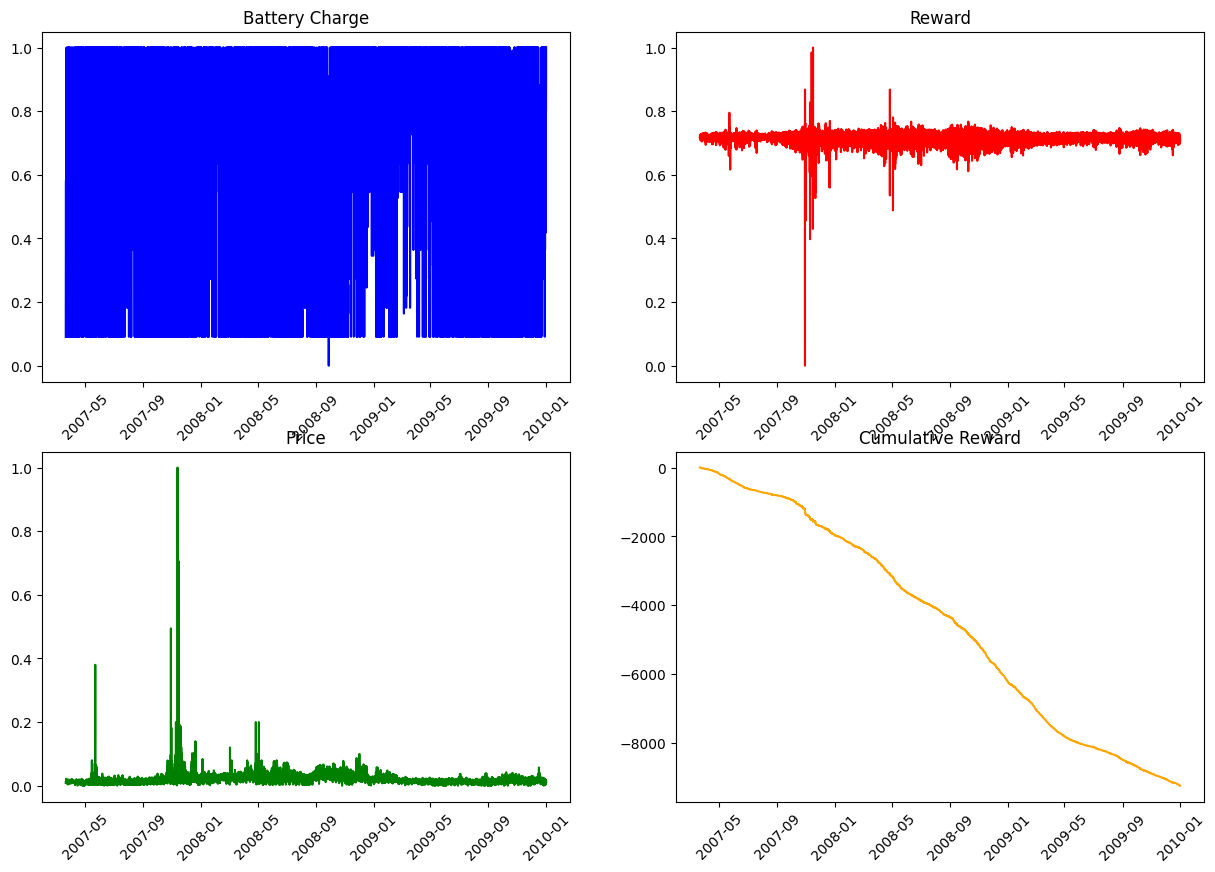

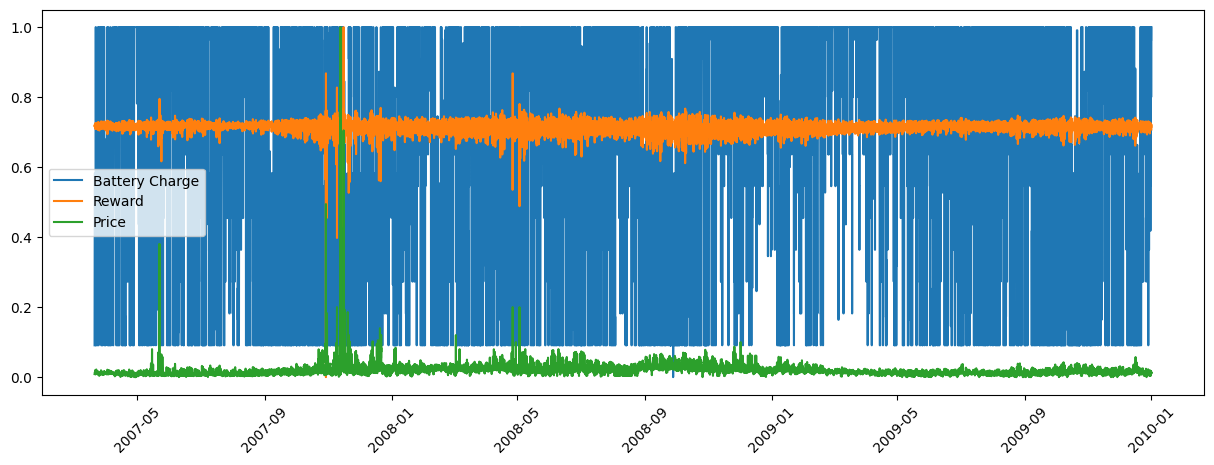

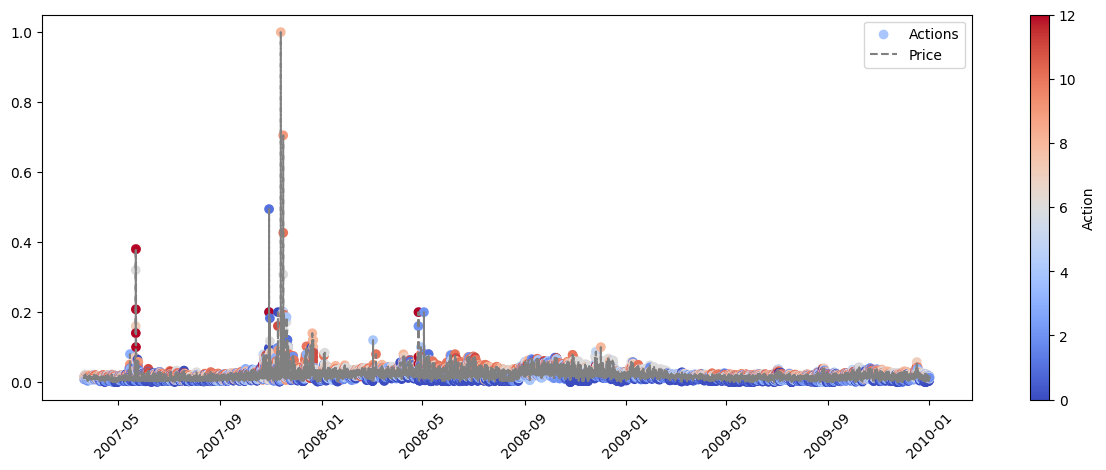

In [53]:
#print total actions
print(f'Total actions: {len([action for action in eval_rule.actions if action != 6])}')

#print buy actions
print(f'Buy actions: {len([action for action in eval_rule.actions if action > 6])}')
#print sell actions
print(f'Sell actions: {len([action for action in eval_rule.actions if action < 6])}')

#total balance
print(f'Cumulative balance: {np.sum(eval_rule.balance)}')


# Visualize Rule-Based Agent
plot_range = (0, 100000)
plotter = Plotter(eval_rule, range = plot_range)
plotter.plot_single()
plotter.plot_all()
plotter.plot_actions()


## DDQN AGENT

In [5]:
seed = 2705
rep = 5000000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 499999
epsilon_min = 0.05
learning_rate = 5e-5
price_horizon = 48
future_horizon = 0
hidden_dim = 64
verbose = True

In [6]:
if TRAIN:
    
    # Initialize Environment
    env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
    env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, extra_penalty = True)

    #Initialize DQN
    agent = DDQNAgent(env_name = 'gym_env/BatteryGrid-v0', 
                    df = train, 
                    device = 'cpu', 
                    epsilon_decay = epsilon_decay, 
                    epsilon_start = epsilon, 
                    epsilon_end = epsilon_min, 
                    discount_rate = gamma, 
                    lr = learning_rate, 
                    buffer_size = 50000, 
                    price_horizon = price_horizon, 
                    hidden_dim=hidden_dim)
        
    obs, info = env.reset() # Reset environment and get initial observation

    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    for i in tqdm(range(rep)):
        
        action = agent.choose_action(i, obs['tensor'], greedy = False)
        new_obs,r,t,info = env.step(action)

        # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
        agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))
        
        #Update DQN
        loss = agent.optimize(batch_size)
        
        # Update values
        episode_balance += info['balance']
        episode_reward += r
        episode_loss += loss
        
        # New observation
        obs = new_obs

        if t:
            obs, info = env.reset()
            episode_counter += 1
            print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
            episode_loss = 0
            episode_balance = 0
            episode_reward = 0 
            
    # Save agent
    torch.save(agent.dqn_predict.state_dict(), 'models/agent_penalty.pt')

/Users/jorisholshuijsen/Documents/Artificial Intelligence/1e Jaar/Reinforcement Learning Project/BatteryGrid/venv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
  1%|          | 26488/5000000 [00:20<1:07:56, 1220.00it/s]

Episode  1 Balance:  -14550.934789275987 Reward:  -16207.94258927599 Loss:  5225.057506389916


  1%|          | 52642/5000000 [00:41<1:05:37, 1256.48it/s]

Episode  2 Balance:  -13686.955233073068 Reward:  -15299.945923073132 Loss:  4560.7556210737675


  2%|▏         | 79003/5000000 [01:02<1:05:23, 1254.11it/s]

Episode  3 Balance:  -12572.082129948001 Reward:  -14173.21656994799 Loss:  4132.592292312533


  2%|▏         | 105262/5000000 [01:24<1:06:18, 1230.42it/s]

Episode  4 Balance:  -11927.650855575032 Reward:  -13535.689255575044 Loss:  4003.5553132798523


  3%|▎         | 131411/5000000 [01:46<1:05:51, 1232.09it/s]

Episode  5 Balance:  -11195.902169155015 Reward:  -12596.687339155034 Loss:  3608.1685590241104


  3%|▎         | 140071/5000000 [01:53<1:05:49, 1230.53it/s]


KeyboardInterrupt: 

In [ ]:
# Load agent
agent = DDQNAgent(env_name = 'gym_env/BatteryGrid-v0', 
                  df = train, 
                  device = 'cpu', 
                  epsilon_decay = epsilon_decay, 
                  epsilon_start = epsilon, 
                  epsilon_end = epsilon_min, 
                  discount_rate = gamma, 
                  lr = learning_rate, 
                  buffer_size = 50000, 
                  price_horizon = price_horizon, 
                  hidden_dim=hidden_dim)

agent.dqn_predict.load_state_dict(torch.load('models/agent_penalty.pt'))


<All keys matched successfully>

In [ ]:
# Evaluate DDQN Agent
df = train
price_horizon = 48

ddqn_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env.setup(df, price_horizon=price_horizon, extra_penalty = False)
eval_ddqn = DDQNEvaluation(df, ddqn_env)
eval_ddqn.evaluate(agent = agent)

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.price_horizon to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.price_horizon` for environment variables or `env.get_wrapper_attr('price_horizon')` that will search the reminding wrappers.
  logger.warn(


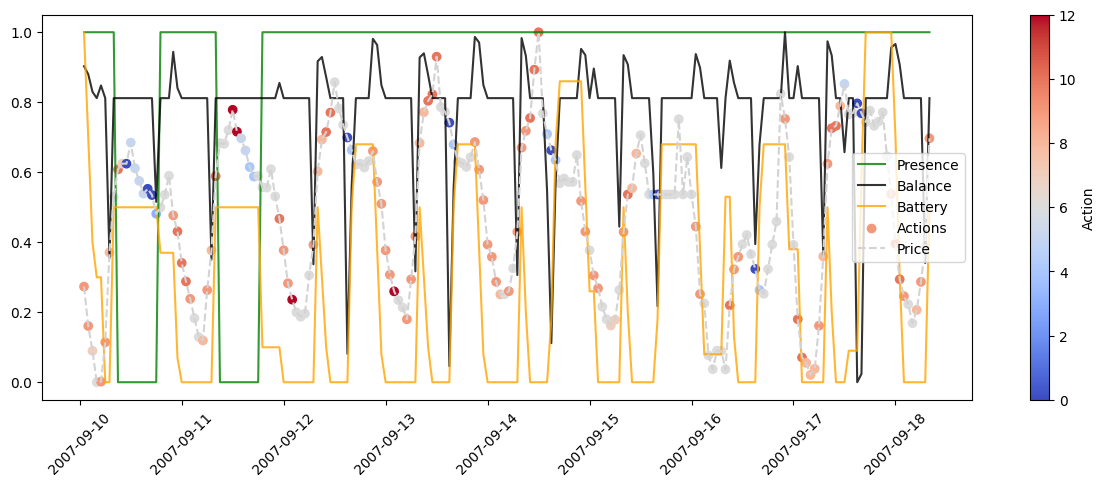

In [ ]:
#Visualize DDQN Agent
plot_range = [6000, 6200]

plotter = Plotter(eval_ddqn, range = plot_range)
#plotter.plot_single()
#plotter.plot_all()
plotter.plot_actions(battery = True, balance=True, presence = True)

In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer 
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


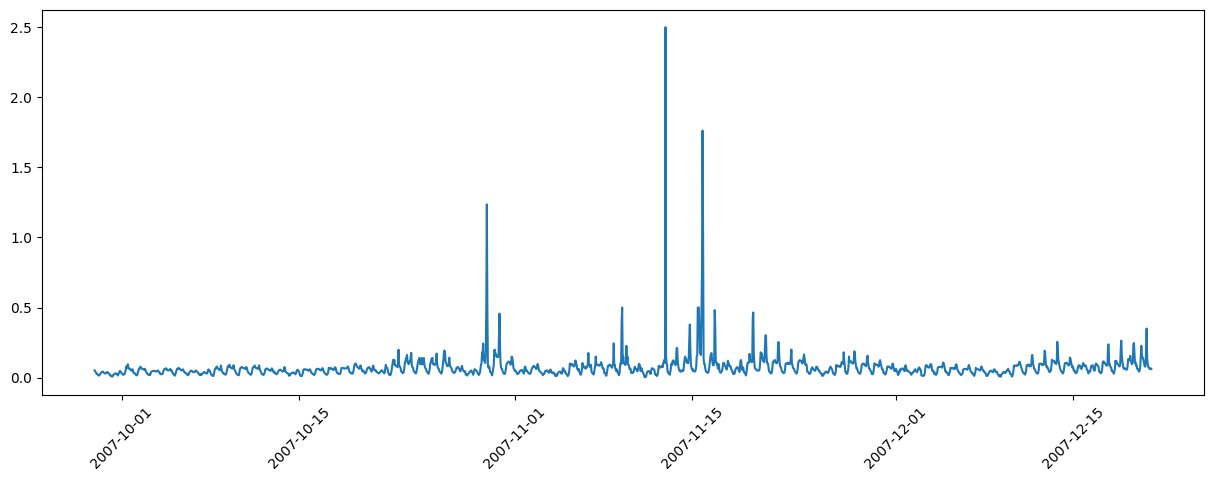

In [ ]:
start = 6500
range = 2000
plt.figure(figsize=(15,5))
plt.plot(train['datetime'][start:(start+range)], train['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

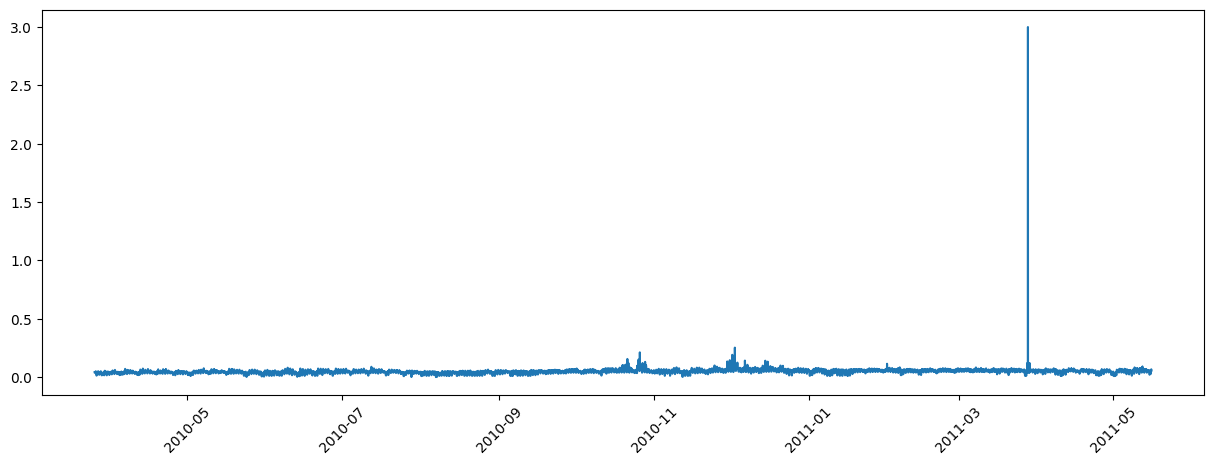

In [ ]:
start = 2000
range = 10000
plt.figure(figsize=(15,5))
plt.plot(val['datetime'][start:(start+range)], val['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

In [ ]:
price_horizon = 48
future_horizon = 0

env = gym.make('gym_env/BatteryGrid-v0')
env.setup(val, price_horizon=price_horizon, future_horizon=future_horizon, verbose=True)
obs,_ = env.reset()
print(obs)

obs,r,t,info = env.step(0)
obs,r,t,info = env.step(1)
obs,r,t,info = env.step(2)
obs,r,t,info = env.step(3)
obs,r,t,info = env.step(4)
obs,r,t,info = env.step(5)
obs,r,t,info = env.step(6)
obs,r,t,info = env.step(7)
obs,r,t,info = env.step(8)
obs,r,t,info = env.step(9)
obs,r,t,info = env.step(10)
obs,r,t,info = env.step(11)




{'battery': -0.5, 'prices': array([-0.76523653, -0.76929427, -0.85788829, -1.01614022, -1.07430118,
       -1.17642101, -1.38336583, -1.59031066, -1.08985586, -1.04183925,
       -0.96947619, -0.74089008, -0.43926462, -0.6421517 , -0.80716652,
       -0.96947619, -0.99449893, -0.38719027, -0.12276077,  0.37498886,
        0.18833275, -0.03957707,  0.60695643,  0.44261789, -0.10247207,
       -0.47781316, -0.36487269, -0.7949933 , -0.9687999 , -0.84706765,
       -0.59954541, -0.06865755,  0.29653919,  0.85244979,  1.17030622,
        1.36440153,  1.52062458,  1.12499477,  0.99649962,  0.70569481,
        0.86191786,  1.50980393,  2.16242404,  2.13266727,  1.41918104,
        1.00123365,  1.25010847,  1.11958445]), 'hour': -0.4583333333333333, 'day': -0.4904109589041096, 'presence': 1, 'tensor': array([-0.5       , -0.76523653, -0.76929427, -0.85788829, -1.01614022,
       -1.07430118, -1.17642101, -1.38336583, -1.59031066, -1.08985586,
       -1.04183925, -0.96947619, -0.74089008, -0.4

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  log

In [ ]:
action = 2
kWh = (6 - action) * 5 # Discretize, such that action 0 means most discharge, i.e., kWh = (5 - 0)* 5 = 25
kWh  -= 2.23 if action == 0 else 0 # Add charging loss

print(kWh)

20
